This notebook reads NX3 data sample from Rito: https://drive.google.com/drive/u/1/folders/1aeFfvOS7OzU3j44-rs_UHGnX9IsUwX-7.

June 20, 2025

In [3]:
import numpy as np

def eConvertLVBinS(fname):
    with open(fname, 'rb') as fid:
        # Read first two doubles (big-endian): Ncoeffs and Nchs
        header = np.fromfile(fid, dtype='>d', count=2)
        Ncoeffs = int(header[0])
        Nchs = int(header[1])
        
        # Read coefficient matrix [Ncoeffs, Nchs] (big-endian)
        coeffs = np.fromfile(fid, dtype='>d', count=Ncoeffs*Nchs)
        coeffs = coeffs.reshape((Ncoeffs, Nchs), order='F')  # Column-major order
        
        # Extract parameters
        dt_vals = 1.0 / coeffs[0, :]      # Sampling intervals (1/frequencies)
        offsets = coeffs[1, :]             # DC offsets
        gains = coeffs[2:, :]              # Polynomial coefficients
        
        # Read int16 time-series data [Nchs, Nsamples] (big-endian)
        data_int16 = np.fromfile(fid, dtype='>i2')
        Nsamples = data_int16.size // Nchs
        data_int16 = data_int16.reshape((Nchs, Nsamples), order='F')
        
        # Initialize output with offsets
        b = np.tile(offsets[:, np.newaxis], (1, Nsamples))
        
        # Apply polynomial calibration: b += Σ(gains_k * data^k)
        for k in range(gains.shape[0]):
            exponent = k + 1
            term = gains[k, :][:, np.newaxis] * (data_int16 ** exponent)
            b += term
        
        # Create time vector using first channel's dt
        time_vector = np.arange(Nsamples) * dt_vals[0]
        
        # Combine time vector with channel data (transposed to [Nsamples, Nchs])
        return np.column_stack((time_vector, b.T))

# Example usage
filenum = "timeS66.bin"
a = eConvertLVBinS(filenum)

tt = a[:, 0]    # Time vector (1st column)
I = a[:, 1]     # I-channel data (2nd column)
Q = a[:, 2]     # Q-channel data (3rd column)

fs = 1 / np.mean(np.diff(tt))  # Calculate sampling frequency
dt = 1 / fs
Z_ts_raw = I + 1j * Q          # Create complex signal

np.save("test_read_waveforms_nx3.npy", Z_ts_raw)

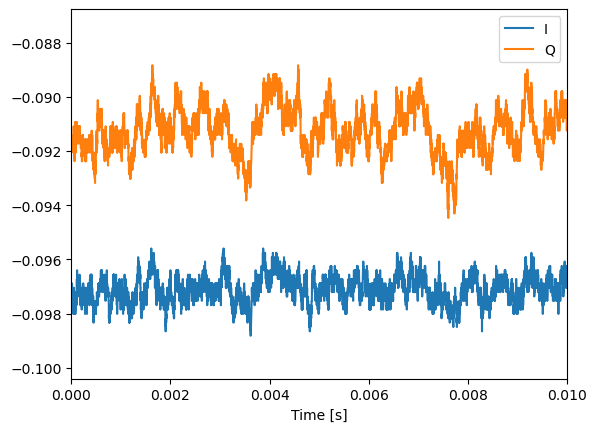

In [4]:
import matplotlib.pyplot as plt
plt.plot(tt, I, label="I")
plt.plot(tt, Q, label="Q")
plt.xlabel("Time [s]")
plt.xlim(0, 0.01)
plt.legend()

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


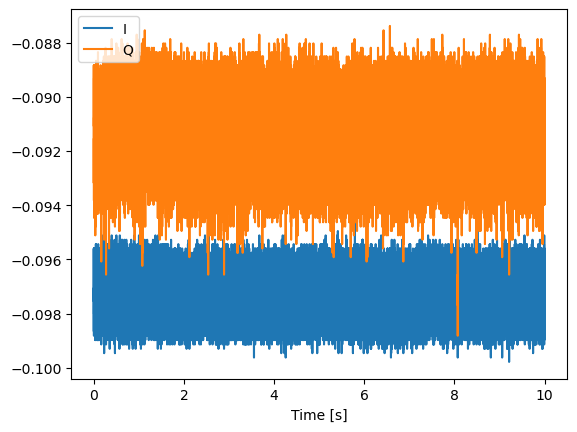

In [5]:
import matplotlib.pyplot as plt
plt.plot(tt, I, label="I")
plt.plot(tt, Q, label="Q")
plt.xlabel("Time [s]")
plt.legend()